In [ ]:
%pip install git+https://github.com/cioos-siooc/ocean-data-parser.git

%pip install folium
%pip install plotly

## Install packages

In [ ]:
%pip install git+https://github.com/cioos-siooc/ocean-data-parser.git

%pip install folium
%pip install plotly

## Imports

In [6]:
from ocean_data_parser.parsers import nmea
import pandas as pd
import xarray as xr
from glob import glob
from tqdm import tqdm
import requests
import folium

# Download test data 
NMEA test data is available here:

https://github.com/HakaiInstitute/ocean-data-parser/tree/main/tests/parsers_test_files/nmea

In [2]:
# retrieve raw data


def download_file_from_github(raw_url):
    """Download a github raw file localy"""
    file_path = raw_url.split("/")[-1]
    response = requests.get(raw_url)
    with open(file_path, "w") as f:
        f.write(response.text)
    return file_path


nmea_files = [
    "https://raw.githubusercontent.com/cioos-siooc/ocean-data-parser/development/tests/parsers_test_files/nmea/seaspan/nmeadata-2022-07-04_00.txt",
    "https://raw.githubusercontent.com/cioos-siooc/ocean-data-parser/development/tests/parsers_test_files/nmea/seaspan/nmeadata-2022-07-04_01.txt",
    "https://raw.githubusercontent.com/cioos-siooc/ocean-data-parser/development/tests/parsers_test_files/nmea/seaspan/nmeadata-2022-07-04_02.txt",
    "https://raw.githubusercontent.com/cioos-siooc/ocean-data-parser/development/tests/parsers_test_files/nmea/seaspan/nmeadata-2022-07-04_03.txt",
]

files = [download_file_from_github(file) for file in nmea_files]

## Load NMEA data 

Here we load the different NMEA files and convert them a pandas dataframe.

In [50]:
nmea_files = glob("nmeadata-*.txt")
nmea_parsed = [
    nmea.file(file) for file in tqdm(nmea_files, desc="Import nmea files", unit="file")
]
# Aggregate all files
ds = xr.concat(nmea_parsed, dim="index")
ds

Import nmea files: 100%|██████████| 4/4 [00:00<00:00,  5.21file/s]


<xarray.Dataset>
Dimensions:                                (index: 28800)
Coordinates:
  * index                                  (index) int64 0 1 2 ... 7198 7199
Data variables: (12/50)
    row                                    (index) float64 0.0 1.0 ... 7.199e+03
    prefix                                 (index) object '20220704 020001+00...
    talker                                 (index) object 'II' 'HC' ... 'WI'
    sentence_type                          (index) object 'MDA' 'HDT' ... 'MWV'
    subtype                                (index) object None None ... None
    manufacturer                           (index) object None None ... None
    ...                                     ...
    wind_angle                             (index) float64 nan nan ... nan 339.8
    reference                              (index) object None None ... None 'R'
    wind_speed                             (index) float64 nan nan ... nan 1.19
    wind_speed_units                       (index) object None None ... None 'N'
    wind_speed_relative_to_platform_knots  (index) float64 nan nan ... nan 1.19
    wind_direction_relative_to_platform    (index) float64 nan nan ... nan 339.8

## Convert prefix of NMEA to datetime

In [66]:
# In this case the each rows prefix prior to the NMEA string is a timestamp, convert it to a datetime object
ds["computer_time"] = (
    ds["prefix"].dims,
    pd.Series(pd.to_datetime(ds["prefix"].str.strip(), format="%Y%m%d %H%M%S%z")),
)

# Reseample NMEA data to 2s

In [103]:
ds_resampled = (
    ds.swap_dims({"index": "computer_time"})
    .sortby("computer_time")
    .resample({"computer_time": "2s"})
    .first()
)
ds_resampled

<xarray.Dataset>
Dimensions:                                (computer_time: 7200)
Coordinates:
  * computer_time                          (computer_time) datetime64[ns] 202...
Data variables: (12/50)
    row                                    (computer_time) float64 0.0 ... 7....
    prefix                                 (computer_time) <U22 '20220704 000...
    talker                                 (computer_time) <U2 'II' ... 'II'
    sentence_type                          (computer_time) <U3 'MDA' ... 'MDA'
    subtype                                (computer_time) object None ... None
    manufacturer                           (computer_time) object None ... None
    ...                                     ...
    wind_angle                             (computer_time) float64 284.6 ... ...
    reference                              (computer_time) <U1 'R' 'R' ... 'R'
    wind_speed                             (computer_time) float64 2.68 ... 2...
    wind_speed_units                       (computer_time) <U1 'N' 'N' ... 'N'
    wind_speed_relative_to_platform_knots  (computer_time) float64 2.68 ... 2...
    wind_direction_relative_to_platform    (computer_time) float64 284.6 ... ...

# Plot Resulting Data

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

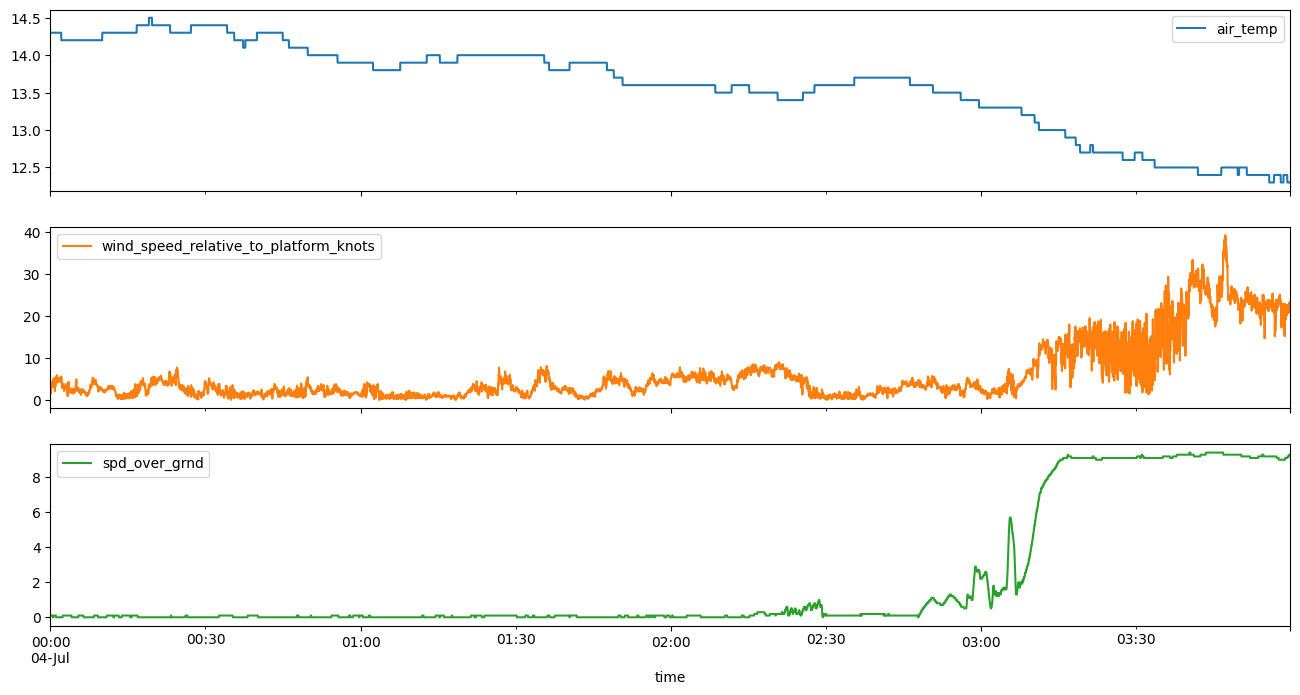

In [102]:
# Plot data
ds_resampled[
    [
        "air_temp",
        "wind_speed_relative_to_platform_knots",
        "spd_over_grnd",
    ]
].to_dataframe().plot(xlabel="time", figsize=(16, 8), subplots=True)

# Plot position on a map

In [101]:
# Plot lat/lon on a map
lat, lon = "latitude_degrees_north", "longitude_degrees_east"
df = ds_resampled.to_dataframe()
map = folium.Map(location=df[[lat, lon]].mean())
folium.PolyLine(df[[lat, lon]].dropna().values, color="red").add_to(map)
map